In [24]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
import seaborn as sns

import sklearn
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


import optuna

In [2]:
data = pd.read_csv('/Users/abilfad/Documents/CODE/weather-forecasting-datavidia/appended_data.csv',index_col='time')
data.drop('Unnamed: 0',axis=1)
data.head()

,Unnamed: 0,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),...,soil_temperature_28_to_100cm (°C)_min,soil_temperature_100_to_255cm (°C)_min,soil_moisture_0_to_7cm (m³/m³)_min,soil_moisture_7_to_28cm (m³/m³)_min,soil_moisture_28_to_100cm (m³/m³)_min,soil_moisture_100_to_255cm (m³/m³)_min,city_min,month,rainy,year
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0,21.1,16.5,24.5,18.3,2018-01-01T06:30,2018-01-01T18:28,5.15,22.0,0.0,...,19.4,19.8,0.404,0.419,0.391,0.432,b,1,True,2018
2018-01-02,1,22.2,16.1,25.0,17.7,2018-01-02T06:30,2018-01-02T18:29,11.23,15.7,0.0,...,19.4,19.8,0.399,0.420,0.403,0.431,b,1,True,2018
2018-01-03,2,22.0,16.0,25.2,17.7,2018-01-03T06:31,2018-01-03T18:29,5.14,21.2,0.0,...,19.4,19.8,0.411,0.420,0.409,0.431,b,1,True,2018
2018-01-04,3,21.8,15.6,25.2,17.0,2018-01-04T06:31,2018-01-04T18:30,6.80,9.1,0.0,...,19.4,19.8,0.410,0.422,0.420,0.431,b,1,True,2018
2018-01-05,4,23.3,16.4,25.7,17.9,2018-01-05T06:31,2018-01-05T18:30,18.50,0.7,0.0,...,19.3,19.8,0.398,0.409,0.415,0.430,b,1,True,2018


In [3]:
abs(data.corr()['rain_sum (mm)']).sort_values(ascending=False)[:20]


rain_sum (mm)                          1.000000
relativehumidity_2m (%)_min            0.529856
elevation                              0.492999
surface_pressure (hPa)_max             0.486459
surface_pressure (hPa)_min             0.484612
cloudcover (%)_min                     0.470271
cloudcover_mid (%)_max                 0.424830
cloudcover_high (%)_min                0.424766
cloudcover_low (%)_max                 0.423922
cloudcover (%)_max                     0.380604
diffuse_radiation (W/m²)_max           0.359569
direct_normal_irradiance (W/m²)_max    0.350554
relativehumidity_2m (%)_max            0.341589
windspeed_10m_max (km/h)               0.333069
windspeed_10m (km/h)_max               0.333069
windspeed_100m (km/h)_max              0.314315
soil_moisture_0_to_7cm (m³/m³)_max     0.312814
windspeed_10m (km/h)_min               0.300304
vapor_pressure_deficit (kPa)_min       0.293492
vapor_pressure_deficit (kPa)_max       0.290577
Name: rain_sum (mm), dtype: float64

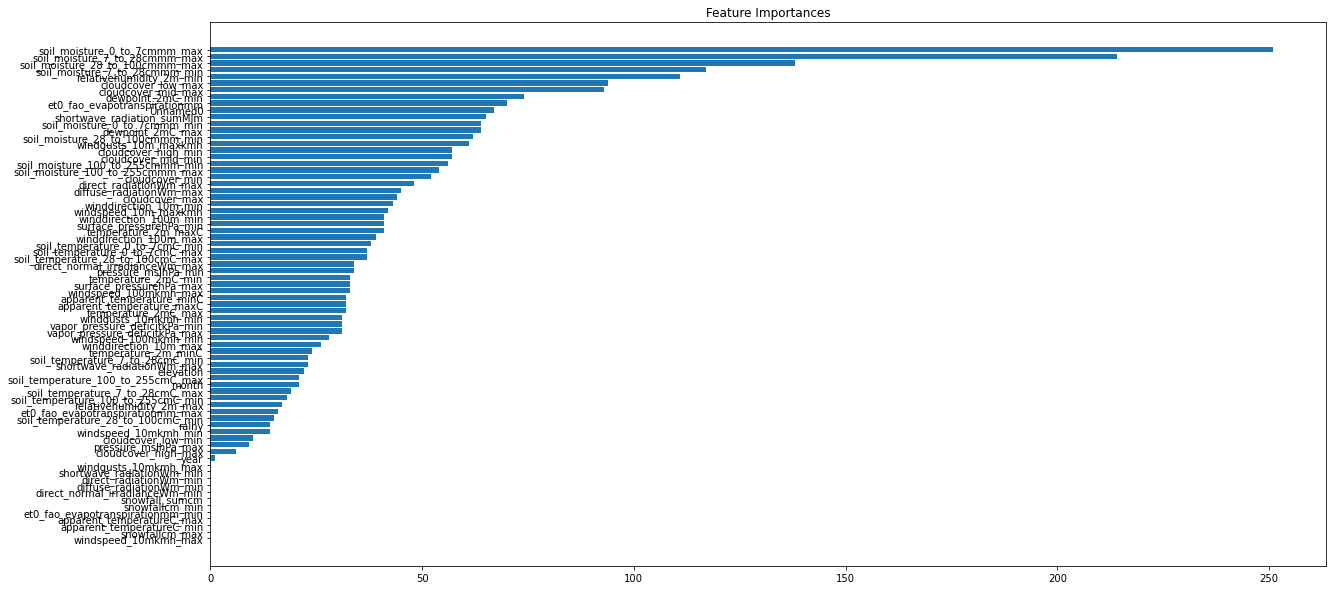

[ 67  41  24  32  32  65   0  42  61  70  22  32  17  64   0   9  33   0
  44  94  93   6  23  48  45  34   0  33  26  39   0  16  31  37  19  37
  21 251 214 138  54  33 111  74   0  34  41   0  52  10  57  57   0   0
   0   0  14  28  43  41  31   0  31  38  23  15  18  64 117  62  56  21
  14   1]


In [30]:
def tree_importance(train,model_):  
  # initialize the model : Tree Based
  model = model_
  feature = [x for x in train.columns if x not in ["rain_summm",'sunriseiso8601', 'sunsetiso8601', 'city', 'city_max', 'city_min']]
  model.fit(train[feature],train['rain_summm'])

  importances = model.feature_importances_
  idxs = np.argsort(importances)

  plt.title('Feature Importances')
  plt.barh(range(len(idxs)), importances[idxs], align='center')
  plt.yticks(range(len(idxs)), [feature[i] for i in idxs]) 
  #plt.xlabel(f'{model_}')
  plt.show()
  print(importances)
if __name__ == "__main__":
  import re
  data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
  cols =[x for x in data.columns if data[x].dtypes!= "O"]
  for i in [LGBMRegressor(random_state=0)] : 
    tree_importance(data,i)

NameError: name 'importances' is not defined